<a href="https://colab.research.google.com/github/juanxiu/lgaimers/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Project] 텍스트 데이터 기반 문서 분류 프로젝트

---

## 프로젝트 목표
- 한국어 원문 데이터(법원 판결문)의 요약문을 카테고리('일반행정', '세무', '특허', '형사', '민사', '가사')별로 분류하는 프로젝트 수행

---

## 데이터 출처
-  https://aihub.or.kr/aidata/8054

---

## 프로젝트 개요

이번 프로젝트에서는 LSTM 기술을 활용하여 법원 판결문을 분류하는 프로젝트를 수행합니다.

법원 판결문 데이터를 형태소 분석기를 활용하여 한국어 텍스트를 전처리하는 방법과 이를 학습하여 분류 성능을 확인합니다.

---

In [ ]:
!pip install --upgrade aiohttp

     |████████████████████████████████| 1.3 MB 12.9 MB/s            
     |████████████████████████████████| 129 kB 90.7 MB/s            
     |████████████████████████████████| 240 kB 102.7 MB/s            
     |████████████████████████████████| 308 kB 100.1 MB/s            
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


## 1. 데이터 읽기

pandas를 사용하여 `project_data_all3.json` 데이터를 읽고 dataframe 형태로 저장해 봅시다.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 엘리스 환경에서 한글 폰트를 사용하기 위한 코드입니다.
font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

plt.rc('font', family='NanumBarunGothic')

In [ ]:
# 데이터 파일 경로 정의하기
fp = './project_data_all3.json'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.random.set_seed(0)

In [ ]:
# json 파일 읽기
df = pd.read_json(fp)
df.head()

,id,category,size,char_count,publish_date,title,text,annotator_id,document_quality_scores,extractive,abstractive
0,83587,일반행정,small,509,20041125,사도개설허가취소신청거부처분취소,"[[{'index': 0, 'sentence': '[1] 취소소송은 처분 등이 있음...",3852,"{'readable': 3, 'accurate': 4, 'informative': ...","[0, 4, 6]","[취소소송은 처분 등이 있다는 것을 안 때로부터 90일 이내에 제기하여야 하고, 행..."
1,83588,일반행정,medium,845,20041126,노선배분취소처분취소·국제선정기항공운송사업노선면허거부처분취소,"[[{'index': 0, 'sentence': '[1] 항고소송의 대상이 되는 행...",3814,"{'readable': 4, 'accurate': 4, 'informative': ...","[0, 4, 9]",[항고소송의 대상이 되는 행정처분이란 일반 국민의 권리의무에 직접 영향을 미치는 행...
2,83590,세무,small,425,20041125,취득세부과처분취소,"[[{'index': 0, 'sentence': '취득세는 본래 재화의 이전이라는 ...",3710,"{'readable': 3, 'accurate': 3, 'informative': ...","[1, 2, 3]","[취득세는 사실상의 취득행위 자체를 과세객체로 하고, 지방세법에 따르면 부동산 취득..."
3,83591,세무,small,292,20041126,관세부과처분취소,"[[{'index': 0, 'sentence': '[1] 행정처분이 당연무효라고 하...",3708,"{'readable': 3, 'accurate': 3, 'informative': ...","[0, 1, 5]","[행정처분이 당연무효라고 하기 위해서는 하자가 중대, 명백해야 하는데 세관출장소장이..."
4,83592,특허,small,275,20041126,거절결정(상),"[[{'index': 0, 'sentence': '[1] 등록출원한 상표가 상표법 ...",4255,"{'readable': 5, 'accurate': 5, 'informative': ...","[0, 1, 3]",[상표법에 따라 상표가 등록받을 수 있는지의 여부는 구체적으로 판단하므로 출원상표 ...


먼저 분류해야할 카테고리를 확인합니다.

In [ ]:
# 먼저 카테고리 종류를 확인
df.category.unique()

array(['일반행정', '세무', '특허', '형사', '민사', '가사'], dtype=object)

그래프를 활용하여 카테고리 별로 데이터 분포를 확인합니다.

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='category', ylabel='count'>

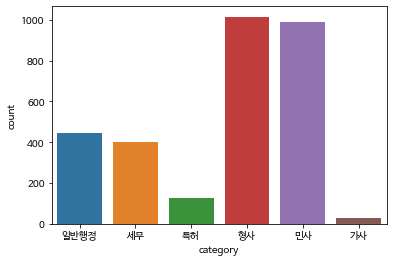

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# 카테고리 분포 확인
fig, axe = plt.subplots(ncols=1)
sns.countplot(df.category)

위 그래프를 확인하면, 형사와 민사가 가장 많고 특허나 가사 요약문은 상대적으로 적다는 것을 확인할 수 있습니다. 그렇기 때문에 데이터를 학습하기 위하여 테스트셋을 분류할 때 비율을 유지해주는 것이 좋습니다. train_test_split 메서드에서 stratify 옵션으로 비율을 유지할 수 있습니다.

카테고리를 정답 레이블로 활용하기 위하여 숫자데이터로 치환합니다.

In [ ]:
# category 컬럼 데이터 변경
df['category'] = df['category'].replace({'가사': 0, '형사': 1, '특허': 2, '민사': 3, '일반행정': 4, '세무': 5})

정답 레이블이 되는 `category`데이터를 `target`변수에 저장합니다.

In [ ]:
target = df['category'].values

# 데이터의 개수를 확인
print(len(target))

3004


학습할 요약문 데이터 `abstractive`를 `data`변수에 저장합니다.

In [ ]:
data = df['abstractive'].values

# 데이터의 개수를 확인
print(len(data))

3004


---

## 2. 형태소 분석하기

KoNLPy("코엔엘파이"라고 읽습니다)는 한국어 정보처리를 위한 파이썬 패키지입니다.

KoNLPy에는 형태소를 분석하고 품사를 태깅할 수 있는 여러개의 패키지를 제공합니다. 여러가지 품사 태거들의 비교는 https://konlpy.org/ko/latest/morph/ 에서 확인할 수 있습니다.

이번 프로젝트에서는 Okt(Twitter) 클래스를 활용하겠습니다.

Stemming(어간 추출)은 어형이 변형된 단어로부터 접사 등을 제거하고 그 `단어의 어간을 분리`하는 것을 말합니다.[위키백과]

형태소는 두 가지 종류가 있습니다. 각각 어간(stem)과 접사(affix)입니다.

1) 어간(stem)
: 단어의 의미를 담고 있는 단어의 핵심 부분.

2) 접사(affix)
: 단어에 추가적인 의미를 주는 부분.

stemming은 정해진 규칙만 보고 단어의 의미를 구분하기 때문에, 어간 추출 후에 나오는 결과 단어는 `사전에 존재하지 않는 단어`일 수도 있습니다.

In [ ]:
# 판결요약문을 KoNLPy 의 Okt 클래스로 형태소 분석
from konlpy.tag import Okt

# Okt 객체 선언
okt = Okt()

# stemming기반 형태소 분석
# 먼저 요약문 1개만 품사 태깅을 해보겠습니다.
pos_results = okt.pos(data[0][0], norm=True, stem=True)

# 품사를 태깅한다는 것은 주어진 텍스트를 형태소 단위로 나누고 명사, 조사, 동사 등의 형태소를 배열 형태로 만다는 과정입니다.
print(pos_results)

[('취소소송', 'Noun'), ('은', 'Josa'), ('처분', 'Noun'), ('등', 'Noun'), ('이', 'Josa'), ('있다', 'Adjective'), ('것', 'Noun'), ('을', 'Josa'), ('안', 'Noun'), ('때', 'Noun'), ('로부터', 'Noun'), ('90일', 'Number'), ('이내', 'Noun'), ('에', 'Josa'), ('제기', 'Noun'), ('하다', 'Verb'), ('하다', 'Verb'), (',', 'Punctuation'), ('행정처분', 'Noun'), ('에서의', 'Josa'), ('허가', 'Noun'), ('에', 'Josa'), ('붙다', 'Verb'), ('기한', 'Noun'), ('이', 'Josa'), ('부당하다', 'Adjective'), ('짧다', 'Adjective'), ('경우', 'Noun'), ('에는', 'Josa'), ('이르다', 'Verb'), ('허가', 'Noun'), ('조건', 'Noun'), ('존속', 'Noun'), ('기간', 'Noun'), ('으로', 'Josa'), ('보아', 'Noun'), ('서', 'Josa'), ('그', 'Noun'), ('기한', 'Noun'), ('의', 'Josa'), ('도래', 'Noun'), ('로', 'Josa'), ('조건', 'Noun'), ('개정', 'Noun'), ('을', 'Josa'), ('고려', 'Noun'), ('하다', 'Verb'), ('해석', 'Noun'), ('하다', 'Verb'), ('수', 'Noun'), ('있다', 'Adjective'), (',', 'Punctuation'), ('사도', 'Noun'), ('개설', 'Noun'), ('허가', 'Noun'), ('의', 'Josa'), ('준공', 'Noun'), ('검사', 'Noun'), ('를', 'Josa'), ('받다', 'Verb'), ('못', 'Noun')

`data_tokenized` 변수에 모든 요약문을 형태소 분석하여 저장하겠습니다.

형태소를 분석하는 메서드는 아래와 같습니다.

1. okt.morphs()

- 텍스트를 형태소 단위로 나눈다. 옵션으로는 norm과 stem이 있다

- norm은 normalize의 약자로 문장을 정규화하는 역할

- stem은 각 단어에서 어간을 추출하는 기능



2. okt.nouns()

- 텍스트에서 명사만 뽑아낸다.



3. okt.phrases()

- 텍스트에서 어절을 뽑아낸다.



4. okt.pos()

- 각 품사를 태깅하는 역할.

- 품사를 태깅한다는 것은 주어진 텍스트를 형태소 단위로 나누고, 나눠진 각 형태소를 그에 해당하는 품사와 함께 리스트화 하는 것을 의미한다.

                                                                ※ 출처(https://soyoung-new-challenge.tistory.com/31)

이번 프로젝트에서는 명사만 추출하는 방식으로 진행하겠습니다.

In [ ]:
# 판결요약문 데이터를 형태소 분석 결과로 저장
data_tokenized = []

# 학습데이터로 명사만 사용
for text in data:
    data_tokenized.append(okt.nouns(text[0]))

# 행태소 분석된 결과를 확인
print(data_tokenized[0])

['취소소송', '처분', '등', '것', '안', '때', '로부터', '이내', '제기', '행정처분', '허가', '기한', '경우', '허가', '조건', '존속', '기간', '보아', '그', '기한', '도래', '조건', '개정', '고려', '해석', '수', '사도', '개설', '허가', '준공', '검사', '못', '것', '사도', '개설', '허가', '자체', '존속', '기간', '볼', '수', '까닭', '것', '실효', '것']


위 결과를 보면 okt.pos의 결과에서 'Noun'으로 된 명사만 남아있는 것을 확인할 수 있습니다.

In [ ]:
# 형태소 분석 결과의 개수를 확인. 이전에 확인한 개수와 동일한 것을 확인할 수 있습니다.
print(len(data_tokenized))

3004


각 문장마다 분리된 형태소, 즉 명사가 몇개씩인지 확인해보겠습니다.

`data_tokenized` 변수의 각 배열마다 몇개의 명사가 들어있는지 히스토그램으로 확인하면 대부분의 요약문이 20~60개의 명사를 가지고 있다는 것을 확인할 수 있습니다.

판결 요약문의 최대 길이 :150
판결 요약문의 평균 길이 :43.73601864181092


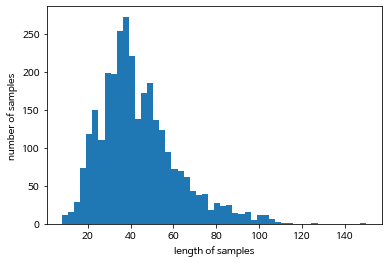

In [ ]:
print('판결 요약문의 최대 길이 :{}'.format(max(len(l) for l in data_tokenized)))
print('판결 요약문의 평균 길이 :{}'.format(sum(map(len, data_tokenized))/len(data_tokenized)))

plt.hist([len(s) for s in data_tokenized], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

---

## 3. 케라스(Keras)의 텍스트 전처리

형태소 분석된 결과를 학습하기 위해서 Keras를 활용하겠습니다.

Keras는 기본적인 전처리 도구들을 제공하는데, `정수 인코딩`을 위해서 Keras의 토크나이저를 사용하겠습니다.

여기서 `정수 인코딩`이란 컴퓨터가 텍스트보다는 숫자를 더 잘 처리할 수 있기 때문에, 자연어 처리 과정에서 텍스트를 숫자로 바꾸는 기법중에 하나입니다. 그리고 그러한 기법들을 본격적으로 적용시키기 위한 첫 단계로 각 단어를 고유한 정수에 맵핑(mapping)시키는 전처리 작업이 필요할 때가 있습니다.

예를 들어 갖고 있는 텍스트에 단어가 5,000개가 있다면, 5,000개의 단어들 각각에 1번부터 5,000번까지 단어와 맵핑되는 고유한 정수, 다른 표현으로는 인덱스를 부여합니다. 가령, book은 150번, dog는 171번, love는 192번, books는 212번과 같이 숫자가 부여됩니다. 인덱스를 부여하는 방법은 여러 가지가 있을 수 있는데 랜덤으로 부여하기도 하지만, 보통은 전처리 또는 빈도수가 높은 단어들만 사용하기 위해서 단어에 대한 빈도수를 기준으로 정렬한 뒤에 부여합니다. [위키독스]

In [ ]:
# Keras의 텍스트 전처리기를 이용하여 정수 인코딩
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

# fit_on_texts()안에 형태소 분석된 데이터를 입력으로 넣으면 빈도수를 기준으로 단어 집합을 생성
tokenizer.fit_on_texts(data_tokenized)

fit_on_texts는 입력한 텍스트로부터 단어 `빈도수가 높은 순`으로 정수 인덱스를 부여합니다.

각 단어에 인덱스가 어떻게 부여되었는지를 보려면, `word_index`를 확인하면 됩니다.

In [ ]:
# 각 단어에 부여된 인덱스 확인
print(tokenizer.word_index)

{'제': 1, '것': 2, '수': 3, '그': 4, '경우': 5, '위': 6, '행위': 7, '등': 8, '해당': 9, '관': 10, '법': 11, '대한': 12, '처분': 13, '항': 14, '규정': 15, '사실': 16, '피고인': 17, '및': 18, '이': 19, '볼': 20, '때': 21, '인정': 22, '토지': 23, '원고': 24, '구': 25, '회사': 26, '등기': 27, '후': 28, '청구': 29, '함': 30, '계약': 31, '사업': 32, '대하': 33, '취득': 34, '의무': 35, '목적': 36, '판단': 37, '피고': 38, '시행': 39, '지급': 40, '취소': 41, '판결': 42, '대상': 43, '사용': 44, '위반': 45, '결정': 46, '성립': 47, '위법': 48, '과세': 49, '사건': 50, '사유': 51, '여부': 52, '부동산': 53, '죄': 54, '소유권': 55, '거래': 56, '내용': 57, '사정': 58, '권리': 59, '법률': 60, '이유': 61, '허가': 62, '기간': 63, '절차': 64, '이전': 65, '발생': 66, '양도': 67, '세법': 68, '로서': 69, '채권': 70, '기재': 71, '업무': 72, '재산': 73, '금': 74, '적용': 75, '이익': 76, '변경': 77, '관계': 78, '정': 79, '다른': 80, '중': 81, '상의': 82, '책임': 83, '무효': 84, '손해': 85, '신청': 86, '방법': 87, '자': 88, '호': 89, '보험': 90, '명의': 91, '소송': 92, '부분': 93, '대해': 94, '확정': 95, '이상': 96, '바': 97, '피해자': 98, '상표': 99, '액': 100, '부과': 101, '범위': 102, '법인':

출력 결과를 보면, '경마', '의향'이란 단어의 인덱스가 가장 크기 때문에 가정 적은 빈도수를 가졌다고 생각할 수 있습니다.

실제로 단어의 빈도수를 확인하려면 `word_counts`를 보면 되고, '경마', '의향' 단어는 1번씩 사용된걸 확인할 수 있습니다.

In [ ]:
# 각 단어의 사용 빈도수 확인
print(tokenizer.word_counts)

OrderedDict([('취소소송', 22), ('처분', 719), ('등', 949), ('것', 2626), ('안', 61), ('때', 584), ('로부터', 122), ('이내', 23), ('제기', 191), ('행정처분', 109), ('허가', 287), ('기한', 59), ('경우', 1657), ('조건', 85), ('존속', 40), ('기간', 286), ('보아', 209), ('그', 2243), ('도래', 13), ('개정', 71), ('고려', 112), ('해석', 155), ('수', 2253), ('사도', 7), ('개설', 43), ('준공', 36), ('검사', 92), ('못', 68), ('자체', 116), ('볼', 596), ('까닭', 3), ('실효', 23), ('항고소송', 19), ('대상', 343), ('일반', 92), ('국민', 42), ('권리', 290), ('의무', 380), ('직접', 132), ('영향', 92), ('행위', 1051), ('정부', 44), ('간', 38), ('항공', 8), ('노선', 5), ('관', 800), ('잠정', 4), ('협정', 5), ('및', 621), ('비밀', 26), ('양해각서', 1), ('건설', 75), ('교통부', 7), ('내부', 28), ('지침', 13), ('대한', 721), ('운수', 35), ('배분', 3), ('해당', 917), ('공익', 71), ('상의', 249), ('필요', 109), ('상대방', 127), ('불이익', 67), ('더욱', 3), ('재량', 95), ('한계', 27), ('탈', 45), ('위법', 330), ('취득세', 22), ('사실', 678), ('취득', 388), ('과세', 326), ('객체', 32), ('지방', 103), ('세법', 275), ('부동산', 317), ('대해', 231), ('등기', 446), ('등록

케라스 토크나이저에서는 숫자를 지정해서 빈도수가 높은 단어를 몇개까지 사용할지를 결정할 수 있습니다.

이번 프로젝트에서는 빈도수 상위 1000개의 단어를 사용한다고 토크나이저를 재정의하겠습니다.

In [ ]:
# 상위 1000개 단어만 학습에 사용

vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(data_tokenized)

위에서 사용한 방법과 같이 `print(tokenizer.word_index)`로 정수 인덱스를 확인해보면 똑같이 7509개의 인덱스가 보입니다.

실제로 1000개의 단어가 적용되는건 `texts_to_sequences`를 사용할 때 적용됩니다.

`print(data_index[0])`의 결과를 보면 정수 인덱스가 1000을 넘지 않습니다.

In [ ]:
# 판결요약문 데이터를 인덱스로 변환
data_index = tokenizer.texts_to_sequences(data_tokenized)
print(data_index[0])

[13, 8, 2, 394, 21, 197, 992, 124, 227, 62, 411, 5, 62, 301, 606, 63, 113, 4, 411, 301, 344, 219, 147, 3, 569, 62, 666, 272, 357, 2, 569, 62, 210, 606, 63, 20, 3, 2, 993, 2]


---

## 4. LSTM으로 판결 요약문 분류하기

텍스트 분류를 LSTM을 통해서 수행하겠습니다.

먼저 `data_index`의 학습할 데이터를 학습데이터 80%, 테스트데이터 20% 비율로 나눠주겠습니다. 그리고 앞서 설명한바와 같이 각 카테고리의 비율을 유지하기 위하여 `stratify` 에 파라미터에 정답 레이블 데이터를 설정해줍니다.

In [ ]:
# LSTM으로 판결요약문 분류하기
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# class 비율(train:validation)에 유지하기 위해 stratify 옵션을 target으로 지정
X_train, X_test, y_train, y_test = train_test_split(data_index, target, test_size=0.2, stratify=target, random_state=100)

학습할 데이터(판결 요약문)에 들어있는 단어의 개수는 모두 다릅니다.

앞서 히스토그램으로 확인해봤을때 각 단어의 평균이 43이기 때문에 단어의 개수를 40개로 동일하게 패딩하겠습니다.

In [ ]:
# 훈련용 판결요약문과 테스트용 판결요약문의 길이, 즉 단어수를 40으로 일치
# 단어수가 40개보다 많으면 나머지는 제거하고 모자르면 0으로 채워짐
max_len = 40

X_train = pad_sequences(X_train, maxlen=max_len) # 훈련용 판결요약문 패딩
X_test = pad_sequences(X_test, maxlen=max_len) # 테스트용 판결요약문 패딩

훈련용 데이터와 테스트용 데이터를 `원-핫 인코딩` 하겠습니다.

`원-핫 인코딩`은 단어 집합의 크기를 벡터의 차원으로 하고, 표현하고 싶은 단어의 인덱스에 1의 값을 부여하고, 다른 인덱스에는 0을 부여하는 단어의 벡터 표현 방식입니다.[위키독스]

이번 실습에서는 카테고리('일반행정', '세무', '특허', '형사', '민사', '가사')의 개수가 6개이므로 벡터의 크기는 6이 됩니다.

In [ ]:
# 훈련용, 테스트용 판결요약문 데이터의 레이블을 원-핫 인코딩

y_train = to_categorical(y_train) # 훈련용 판결요약문 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 판결요약문 레이블의 원-핫 인코딩

`Embedding()`은 최소 두 개의 인자를 받습니다.

첫번째 인자는 단어 집합의 크기, 즉 총 단어의 개수입니다.

두번째 인자는 임베딩 벡터의 출력 차원, 즉 결과로서 나오는 임베딩 벡터의 크기입니다.

결과적으로 아래의 코드는 120차원을 가지는 임베딩 벡터 1,000개를 생성합니다.

마지막으로 6개의 카테고리를 분류해야하므로, 출력층에서는 6개의 뉴런을 사용합니다. 활성화 함수로는 소프트맥스를 사용하여 6개의 확률분포를 만듭니다.

In [ ]:
model = Sequential()
model.add(Embedding(1000, 120))
model.add(LSTM(120))
model.add(Dense(6, activation='softmax'))

검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 5회 증가하면 학습을 조기 종료(Early Stopping) 하겠습니다.

ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장하겠습니다.


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

다중 클래스 분류(Multi-Class Classification) 문제이므로 손실 함수로는 categorical_crossentropy를 사용합니다.

categorical_crossentropy는 모델의 예측값과 실제값에 대해서 두 확률 분포 사이의 거리를 최소화하도록 훈련합니다.


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

이제 학습을 진행합니다.

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
19/19 [==============================] - 7s 182ms/step - loss: 1.6916 - acc: 0.3682 - val_loss: 1.4262 - val_acc: 0.4309

Epoch 00001: val_acc improved from -inf to 0.43095, saving model to best_model.h5
Epoch 2/30
19/19 [==============================] - 2s 128ms/step - loss: 1.3764 - acc: 0.4564 - val_loss: 1.1934 - val_acc: 0.5657

Epoch 00002: val_acc improved from 0.43095 to 0.56572, saving model to best_model.h5
Epoch 3/30
19/19 [==============================] - 2s 99ms/step - loss: 1.0494 - acc: 0.6080 - val_loss: 0.9682 - val_acc: 0.6656

Epoch 00003: val_acc improved from 0.56572 to 0.66556, saving model to best_model.h5
Epoch 4/30
19/19 [==============================] - 2s 98ms/step - loss: 0.8265 - acc: 0.7098 - val_loss: 0.8088 - val_acc: 0.7138

Epoch 00004: val_acc improved from 0.66556 to 0.71381, saving model to best_model.h5
Epoch 5/30
19/19 [==============================] - 2s 98ms/step - loss: 0.5800 - acc: 0.8021 - val_loss: 0.6965 - val_acc: 0.7587

E

마지막으로 검증 데이터에 대한 정확도가 가장 높았을 때 저장된 모델인 `best_model.h5`를 로드하여 성능을 평가합니다.

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

19/19 [==============================] - 0s 8ms/step - loss: 0.6290 - acc: 0.7953

 테스트 정확도: 0.7953


epoch마다 변화하는 훈련데이터와 검증데이터(테스트 데이터)의 손실을 시각화하겠습니다.

검증데이터의 loss값을 확인하면 작아지다가 다시 증가지는게 보입니다. 이는 과적합이 발생했다고 유추할 수 있습니다.[위키독스]

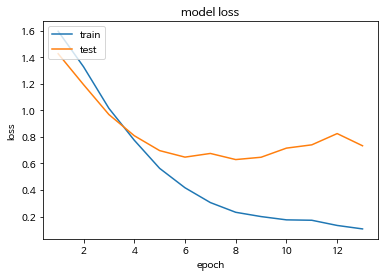

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

## 퀴즈
학습한 모델을 바탕으로 모든 요약문에 대한 예측값을 출력하고자 합니다.

우선, **1. 데이터 읽기** 파트에서 구한 데이터프레임 `df`에서 요약문인 `abstractive`을 바탕으로 `loaded_model`로 예측한 결과를 구하여 `y_all_pred`에 저장했습니다.

`y_all_pred`의 결과물을 `가사, 형사, 특허, 민사, 일반행정, 세무`로 변환하여 `df` 데이터프레임에 `pred` 열로 추가하고자 할 때, 아래 코드를 완성하세요.

### 지시사항

1. 실제 카테고리를 출력하기 위하여 수치형 `category` 열 값을 아래와 같이 범주로 변환합니다.
    - `{0:'가사', 1:'형사', 2:'특허', 3:'민사', 4:'일반행정', 5:'세무'}`
  
  
2. 전체 요약문을 `df['abstractive']` 패딩하여 예측을 위한 입력 변수를 전처리합니다.


3. 0~5의 값으로 예측한 결과물을 저장합니다.


4. `df['pred']`에 예측 결과를 추가합니다.


5. `df['pred']`에 저장된 0~5의 결과를 다시 가사, 형사, 특허, 민사, 일반행정, 세무로 변환합니다.
    - `{0:'가사', 1:'형사', 2:'특허', 3:'민사', 4:'일반행정', 5:'세무'}`


6. 요약문 별 실제 카테고리와 예측 결과를 출력한 결과를 확인합니다.

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 실제 카테고리 값을 변환하기 위한 딕셔너리
category_dict = {0: '가사', 1: '형사', 2: '특허', 3: '민사', 4: '일반행정', 5: '세무'}

# 데이터프레임 df에서 요약문 데이터를 리스트 형태로 변환
texts = df['abstractive'].tolist()

# 원래 사용한 tokenizer와 동일한 설정으로 재정의
tokenizer = Tokenizer(num_words=1000)  # num_words 인자를 사용하여 인덱스 제한
tokenizer.fit_on_texts(texts)  # df['abstractive']로 다시 fit

# 텍스트 토큰화 및 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(texts)

# 요약문을 패딩하여 입력 변수로 전처리
max_len = 40  # 원래 설정된 최대 길이로 패딩
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# 모델로 예측
y_all_pred = loaded_model.predict(padded_sequences)

# 예측 결과를 0~5 값으로 변환
y_all_pred_classes = np.argmax(y_all_pred, axis=1)

# 예측 결과를 데이터프레임에 추가
df['pred'] = y_all_pred_classes

# 예측 결과를 실제 카테고리로 변환
df['pred'] = df['pred'].map(category_dict)

# 실제 카테고리도 변환
df['category'] = df['category'].map(category_dict)

# 요약문 별 실제 카테고리와 예측 결과를 출력
for i in range(len(df)):
    print("요약문:")
    print(df['abstractive'][i])
    print("실제 카테고리: %s, " % df['category'][i])
    print("예측 카테고리: %s \n" % df['pred'][i])


요약문:
['취소소송은 처분 등이 있다는 것을 안 때로부터 90일 이내에 제기하여야 하고, 행정처분에서의 허가에 붙은 기한이 부당하게 짧은 경우에는 이를 허가조건 존속기간으로 보아서 그 기한의 도래로 조건 개정을 고려한다고 해석할 수 있기에, 사도개설허가의 준공검사를 받지 못한 것은 사도개설허가 자체의 존속기간으로 볼 수 없다는 까닭으로 이것이 실효되는 것은 아니다.']
실제 카테고리: 일반행정, 
예측 카테고리: 민사 

요약문:
['항고소송의 대상이 되는 행정처분이란 일반 국민의 권리의무에 직접 영향을 미치는 행위를 가리키는 것으로, 정부 간 항공노선의 개설에 관한 잠정협정 및 비밀양해각서와 건설교통부 내부지침에 의한 항공노선에 대한 운수권배분처분은 항고소송의 대상이 되는 행정처분에 해당하고, 그 처분으로 인해 공익상의 필요에 비해 상대방이 받게 되는 불이익 등이 더욱 큰 경우에는 재량권의 한계를 일탈한 것으로서 그 자체가 위법하다.']
실제 카테고리: 일반행정, 
예측 카테고리: 민사 

요약문:
['취득세는 사실상의 취득행위 자체를 과세객체로 하고, 지방세법에 따르면 부동산 취득에 대해 등기·등록 등을 이행하지 아니한 경우라도 사실상으로 취득한 때에는 이를 취득한 것으로 보도록 규정하고 있으므로, 부동산에 관한 점유취득시효가 완성되면 사실상의 취득행위가 존재한다고 봄이 상당하다고 판시한 사례이다.']
실제 카테고리: 세무, 
예측 카테고리: 민사 

요약문:
['행정처분이 당연무효라고 하기 위해서는 하자가 중대, 명백해야 하는데 세관출장소장이 적법한 권한의 위임 없이 한 관세부과처분은 하자가 중대하지만 명백하지 않아서 당연무효가 아니다.']
실제 카테고리: 세무, 
예측 카테고리: 형사 

요약문:
['상표법에 따라 상표가 등록받을 수 있는지의 여부는 구체적으로 판단하므로 출원상표 " "는 간단하고 흔하게 있는 표장만으로 된 상표라고 보기 어렵다 한 사례이다.']
실제 카테고리: 특허, 
예측 카테고리: 민사 

요약문:
['교통사고처리특례법 제4조 제

## 제출하기

퀴즈 수행 후, 아래 코드를 실행하면 `df` 데이터프레임이 저장된 `submission.pickle` 파일을 제작하여 채점을 받을 수 있습니다.

**아래 코드를 수정하면 채점이 불가능 합니다.**

In [ ]:
import pickle

d = {'quiz': df.values}

with open('submission.pickle', 'wb') as f:
    pickle.dump(d, f)

In [ ]:
# 채점을 수행하기 위하여 로그인
import sys
sys.path.append('vendor')
from elice_challenge import check_score, upload

In [ ]:
# 제출 파일 업로드
await upload()

이전에 업로드 된 파일 삭제중...
업로드가 완료되었습니다.


In [ ]:
# 채점 수행
await check_score()

Quiz: Fail

점수는 0 점 입니다.
